In [64]:
using Flux
using DifferentialEquations
using Plots
using Zygote

In [3]:
# Define the MLP

# We are working with an NN consisting of the input layer and two hidden layers with 10 neurons each.
# 1 -> 10 -> 10 -> 2
# The call- Dense(Input_size, Output_size, activation_function_handle)

model = Chain(
  Dense(1 => 10, tanh),  # Input layer (1 neuron) to first hidden layer (10 neurons)
  Dense(10 => 10, tanh), # First hidden layer to second hidden layer
  Dense(10 => 3)         # Second hidden layer to output layer (2 neurons)
)

Chain(
  Dense(1 => 10, tanh),                 # 20 parameters
  Dense(10 => 10, tanh),                # 110 parameters
  Dense(10 => 3),                       # 33 parameters
)                   # Total: 6 arrays, 163 parameters, 964 bytes.

In [72]:

struct ODEparams
    β::Float32
    γ::Float32
end

function SIR_model!(du, u, params::ODEparams, t)
    S, I, R = u;
    # We always prefer in place modification to reap performance benefits
    du[1] = -params.β*S*I;               #dSdt
    du[2] =  params.β*S*I - params.γ*I;    #dIdt
    du[3] =  params.γ*I;                   #dRdt
end

function SIR_model(u::AbstractMatrix, params::ODEparams)
    # Turns out in-place modifications are not liked by the AutoDifferentation methods in zygote
    S = u[1,:];
    I = u[2,:];
    dS = -params.β.*S.*I;               #dSdt
    dI =  params.β.*S.*I - params.γ.*I;    #dIdt
    dR =  params.γ.*I;                   #dRdt

    # This converts the output to a 3*length(time) matrix
    return permutedims(hcat(dS, dI, dR), (2,1))
end


function DerivativeNNForODE(NN_model, t; nstates = 3)
    T = length(t)
    buf = Zygote.Buffer(zeros32(nstates, T))
    for (j,τ) in enumerate(t)
        J = Flux.jacobian(x -> NN_model([x]), Float32(τ))[1] # gives a 3 element vector
        buf[:,j] = J
    end
    return copy(buf)
end

function Cost_Function(NN_model, ODE_model, ODE_params::ODEparams, Data, t, u0)
    # We need to first take NN(t, θ) and then calculate dNNdt(t, θ). We can compare dNNdt in the ODE Loss. Data Loss will be NN(t, θ)
    # Force time to be of a Float32 type to not clash with Dense
    t = (eltype(t) != Float32) ? map(k -> Float32.(k), t) : t;
    Data32 = Float32.(Data);
    
    NN_pred = NN_model(reshape(t, 1, :))

    dNNdt = DerivativeNNForODE(NN_model, t)

    dudt = ODE_model(NN_pred, ODE_params)

    constraint = any(<(0f0), NN_pred) ? Inf32 : 0f0

    return Float32(Flux.mse(dudt, dNNdt) + Flux.mse(NN_pred, Data32) + constraint);
end


Cost_Function (generic function with 1 method)

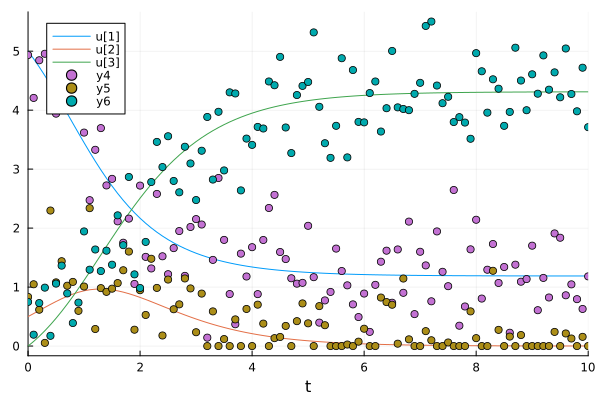

In [6]:
# Generating Synthetic Data 

ODE_param_test = ODEparams(0.5,1.5);
u0 = [5.0, 0.5, 0.0];
time_test = 0.0f0:0.1f0:10.0f0;
prob = DifferentialEquations.ODEProblem(SIR_model!, u0, (time_test[begin], time_test[end]), ODE_param_test);
sol = DifferentialEquations.solve(prob, DifferentialEquations.Tsit5(), saveat=time_test);
sd = 0.5;
noisy_sol = sol .+ randn(size(sol)).*sd;
noisy_sol .= max.(noisy_sol, 0);

plt = Plots.plot(sol)
for i in 1:3
    Plots.scatter!(plt, time_test, noisy_sol[i,:])
end
display(plt)


In [49]:
Flux.mse(model(time_test'), noisy_sol)

7.6182731924258205

In [26]:
function fitNN!(loss::Function,
              model;
              epochs=1000,
              lr = 1e-03,
              print_every=50)

    ps = Flux.trainables(model)
    history = Float32[]
    opt = Flux.Adam()
    
    for epoch in 1:epochs
        # Run the loss and get pullback
        L, back = Flux.withgradient(() -> loss(), ps)
        push!(history, Float32(L))
        
        gs = back(one(L));
        
        Flux.Optimisers.update!(opt, ps, gs)

        if epoch == 1 || epoch % print_every == 0
            @info "epoch $epoch  loss = $(round(L, sigdigits=7))"
        end

    end
    return history
end
      
loss = () -> Cost_Function(model, SIR_model!, ODE_param_test, noisy_sol, time_test, u0)

┌ Warning: `Flux.params(m...)` is deprecated. Use `Flux.trainable(model)` for parameter collection,
│ and the explicit `gradient(m -> loss(m, x, y), model)` for gradient computation.
└ @ Flux C:\Users\RAS365\.julia\packages\Flux\uRn8o\src\deprecations.jl:93
┌ Warning: Implicit gradients such as `withgradient(f, ::Params)` are deprecated in Flux!
│ Please see the docs for new explicit form.
│   caller = fitNN!(loss::var"#81#82", model::Chain{Tuple{Dense{typeof(tanh), Matrix{Float32}, Vector{Float32}}, Dense{typeof(tanh), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}; epochs::Int64, lr::Float64, print_every::Int64) at In[26]:12
└ @ Main .\In[26]:12


LoadError: Mutating arrays is not supported -- called setindex!(Matrix{Float32}, ...)
This error occurs when you ask Zygote to differentiate operations that change
the elements of arrays in place (e.g. setting values with x .= ...)

Possible fixes:
- avoid mutating operations (preferred)
- or read the documentation and solutions for this error
  https://fluxml.ai/Zygote.jl/latest/limitations


In [73]:
Flux.gradient(m -> Cost_Function(m, SIR_model, ODE_param_test, noisy_sol, time_test, u0), model)

LoadError: Mutating arrays is not supported -- called copyto!(SubArray{Float32, 1, Matrix{Float32}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, ...)
This error occurs when you ask Zygote to differentiate operations that change
the elements of arrays in place (e.g. setting values with x .= ...)

Possible fixes:
- avoid mutating operations (preferred)
- or read the documentation and solutions for this error
  https://fluxml.ai/Zygote.jl/latest/limitations


In [67]:
reshape(time_test, 1, :)

1×101 reshape(::StepRangeLen{Float32, Float64, Float64, Int64}, 1, 101) with eltype Float32:
 0.0  0.1  0.2  0.3  0.4  0.5  0.6  …  9.4  9.5  9.6  9.7  9.8  9.9  10.0

In [34]:
model(time_test')[1,:]

101-element Vector{Float32}:
  0.0
 -0.049634602
 -0.09851763
 -0.14594725
 -0.19131377
 -0.23412983
 -0.2740448
 -0.31084564
 -0.34444502
 -0.3748625
 -0.40220156
 -0.42662674
 -0.44834262
  ⋮
 -0.7102002
 -0.71147203
 -0.7127202
 -0.7139449
 -0.7151461
 -0.7163245
 -0.7174802
 -0.71861345
 -0.71972454
 -0.72081375
 -0.72188157
 -0.7229283

In [52]:
vcat

vcat (generic function with 35 methods)

In [41]:
a

0.0f0